In [14]:
from art import *
tprint("Computer Vision Final Semester Project")

  ____                                  _                __     __ _       _                 _____  _                _   ____                               _                 ____                  _              _   
 / ___|  ___   _ __ ___   _ __   _   _ | |_   ___  _ __  \ \   / /(_) ___ (_)  ___   _ __   |  ___|(_) _ __    __ _ | | / ___|   ___  _ __ ___    ___  ___ | |_   ___  _ __  |  _ \  _ __   ___    (_)  ___   ___ | |_ 
| |     / _ \ | '_ ` _ \ | '_ \ | | | || __| / _ \| '__|  \ \ / / | |/ __|| | / _ \ | '_ \  | |_   | || '_ \  / _` || | \___ \  / _ \| '_ ` _ \  / _ \/ __|| __| / _ \| '__| | |_) || '__| / _ \   | | / _ \ / __|| __|
| |___ | (_) || | | | | || |_) || |_| || |_ |  __/| |      \ V /  | |\__ \| || (_) || | | | |  _|  | || | | || (_| || |  ___) ||  __/| | | | | ||  __/\__ \| |_ |  __/| |    |  __/ | |   | (_) |  | ||  __/| (__ | |_ 
 \____| \___/ |_| |_| |_|| .__/  \__,_| \__| \___||_|       \_/   |_||___/|_| \___/ |_| |_| |_|    |_||_| |_| \__,_||_| |____/  \___||_|

In [16]:
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds
import cv2
from skimage.feature import hog, local_binary_pattern
from sklearn.decomposition import PCA, FastICA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

In [17]:
# Step 1: Load Flower Recognition dataset
print("Step 1: Loading Flower Recognition dataset...")
dataset_name = "tf_flowers"
(ds_train, ds_test), ds_info = tfds.load(
    name=dataset_name,
    split=["train[:80%]", "train[80%:]"],
    shuffle_files=True,
    as_supervised=True,
    with_info=True
)
print("Dataset loaded successfully.")

Step 1: Loading Flower Recognition dataset...
Dataset loaded successfully.


In [18]:
# Step 2: Counting classes and images
print("Step 2: Counting classes and images...")
num_classes = ds_info.features["label"].num_classes
num_train_examples = ds_info.splits["train"].num_examples * 0.8
num_test_examples = ds_info.splits["train"].num_examples * 0.2

print("Number of classes:", num_classes)
print("Number of training examples:", num_train_examples)
print("Number of test examples:", num_test_examples)

Step 2: Counting classes and images...
Number of classes: 5
Number of training examples: 2936.0
Number of test examples: 734.0


In [19]:
# Step 2: Counting classes and images
print("Step 2: Counting classes and images...")

# Count occurrences of each class
class_counts_train = {}
class_counts_test = {}

# Count images in training set
for image, label in ds_train:
    class_name = ds_info.features["label"].int2str(label.numpy())
    if class_name in class_counts_train:
        class_counts_train[class_name] += 1
    else:
        class_counts_train[class_name] = 1

# Count images in test set
for image, label in ds_test:
    class_name = ds_info.features["label"].int2str(label.numpy())
    if class_name in class_counts_test:
        class_counts_test[class_name] += 1
    else:
        class_counts_test[class_name] = 1

print("Number of classes:", num_classes)
print("Number of training examples:", num_train_examples)
print("Number of test examples:", num_test_examples)

print("\nClass counts in training set:")
for class_name, count in class_counts_train.items():
    print(f"{class_name}: {count}")

print("\nClass counts in test set:")
for class_name, count in class_counts_test.items():
    print(f"{class_name}: {count}")


Step 2: Counting classes and images...
Number of classes: 5
Number of training examples: 2936.0
Number of test examples: 734.0

Class counts in training set:
daisy: 513
tulips: 613
sunflowers: 561
dandelion: 739
roses: 510

Class counts in test set:
roses: 131
tulips: 186
daisy: 120
sunflowers: 138
dandelion: 159


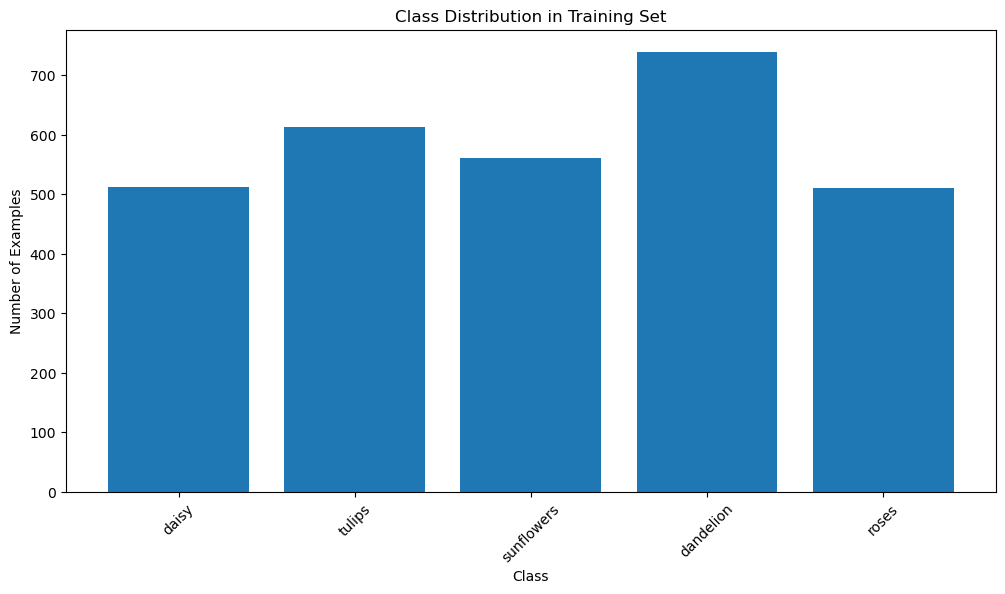

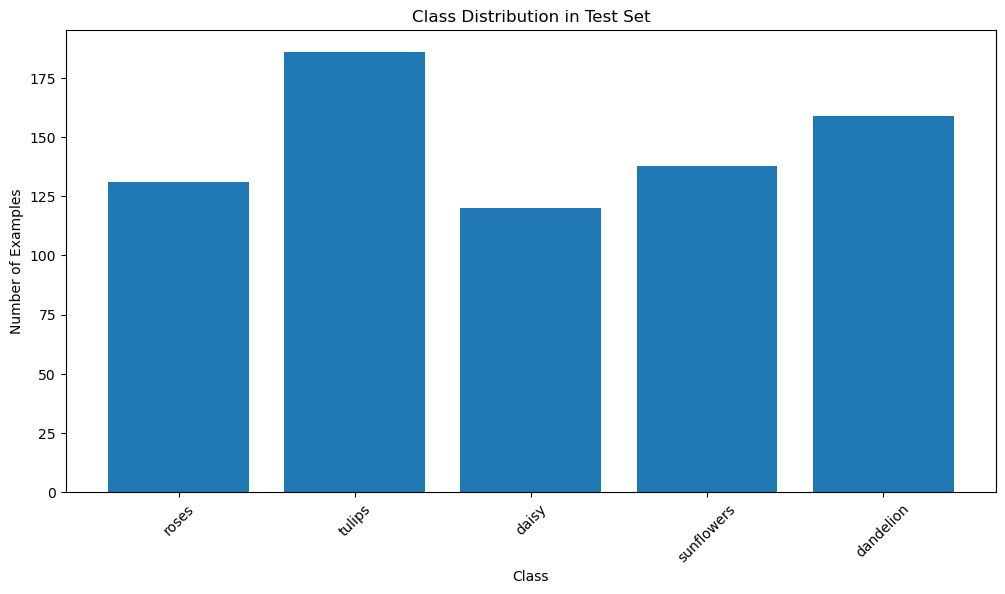

In [20]:
# Plot class distribution
def plot_class_distribution(class_counts, title):
    plt.figure(figsize=(12, 6))
    plt.bar(class_counts.keys(), class_counts.values())
    plt.xlabel('Class')
    plt.ylabel('Number of Examples')
    plt.title(title)
    plt.xticks(rotation=45)
    plt.show()

plot_class_distribution(class_counts_train, 'Class Distribution in Training Set')
plot_class_distribution(class_counts_test, 'Class Distribution in Test Set')

Displaying images from each class in the training set...


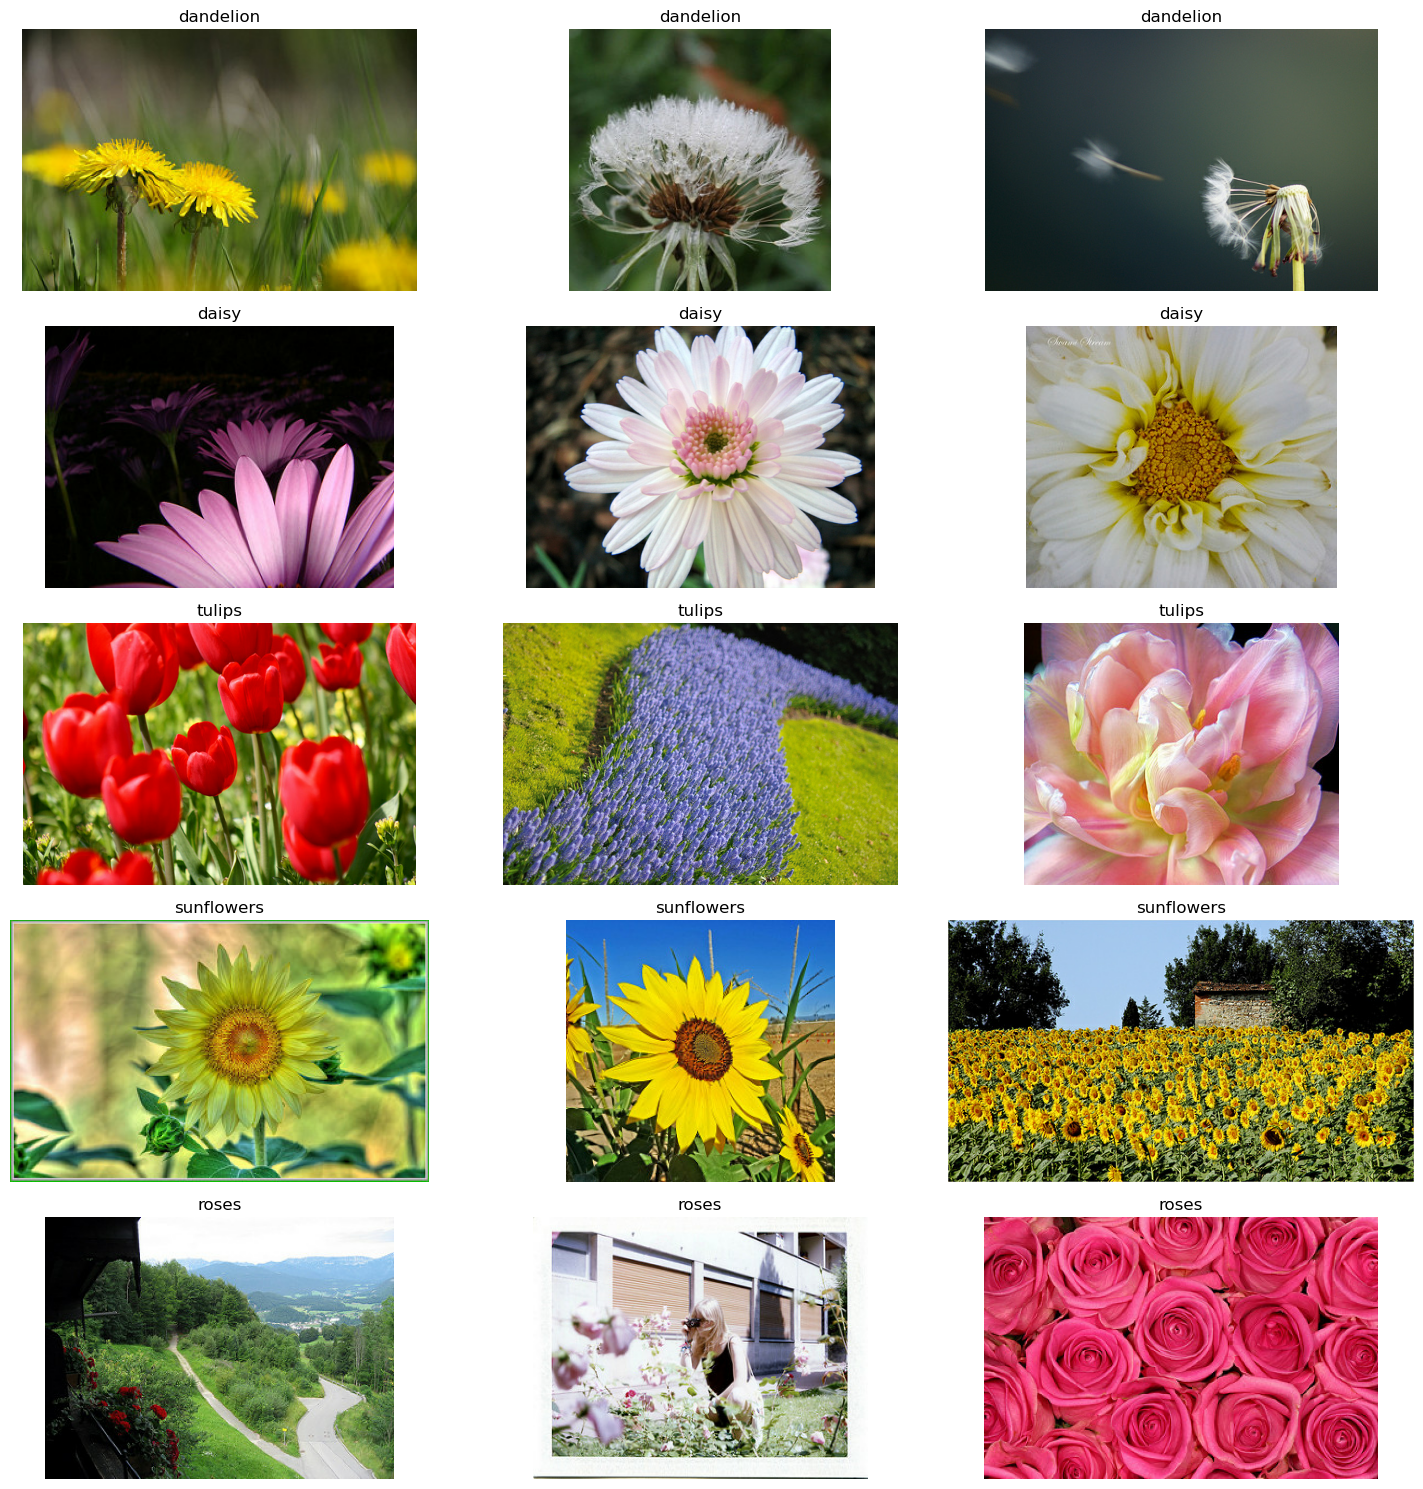

In [21]:
# Function to display images from each class
def display_images_from_each_class(dataset, num_classes, num_images_per_class=3):
    class_names = [ds_info.features["label"].int2str(i) for i in range(num_classes)]
    num_classes = len(class_names)

    fig, axes = plt.subplots(num_classes, num_images_per_class, figsize=(15, 15))
    for i, class_name in enumerate(class_names):
        images = []
        for image, label in dataset:
            if ds_info.features["label"].int2str(label.numpy()) == class_name:
                images.append(image.numpy())
                if len(images) == num_images_per_class:
                    break

        for j in range(num_images_per_class):
            axes[i, j].imshow(images[j])
            axes[i, j].set_title(class_name)
            axes[i, j].axis("off")

    plt.tight_layout()
    plt.show()

# Display images from each class in the training set
print("Displaying images from each class in the training set...")
display_images_from_each_class(ds_train, num_classes)

In [22]:
# Function to balance dataset
def balance_dataset(dataset):
    class_counts = {}
    balanced_data = []

    for image, label in dataset:
        class_name = ds_info.features["label"].int2str(label.numpy())
        if class_name in class_counts:
            class_counts[class_name] += 1
        else:
            class_counts[class_name] = 1
        balanced_data.append((image, label.numpy()))

    min_count = min(class_counts.values())
    balanced_dataset = []

    for class_name in class_counts:
        class_data = [(image, label) for image, label in balanced_data if ds_info.features["label"].int2str(label) == class_name]
        np.random.shuffle(class_data)
        balanced_dataset.extend(class_data[:min_count])

    np.random.shuffle(balanced_dataset)
    return balanced_dataset

In [23]:
def augment_image(image):
    # Convert TensorFlow tensor to numpy array
    image = image.numpy()

    # Augmentation operations
    angle = np.random.randint(-15, 15)
    rows, cols, _ = image.shape
    rotation_matrix = cv2.getRotationMatrix2D((cols / 2, rows / 2), angle, 1)
    image = cv2.warpAffine(image, rotation_matrix, (cols, rows))

    if np.random.rand() < 0.5:
        image = cv2.flip(image, 1)  # Horizontal flip

    scale_factor = np.random.uniform(0.8, 1.2)
    image = cv2.resize(image, None, fx=scale_factor, fy=scale_factor, interpolation=cv2.INTER_LINEAR)

    return image


In [24]:
def preprocess_image(image):
    # Check if the input is a TensorFlow tensor
    if isinstance(image, tf.Tensor):
        # Convert TensorFlow tensor to NumPy array
        image = image.numpy()

    # Normalization
    image = image.astype('float32') / 255.0

    # Convert to grayscale if necessary
    if len(image.shape) == 3:  # Check if image is color
        image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

    # Check if image is already in grayscale
    if image.dtype != np.uint8:  # If not in the correct data type for equalizeHist
        image = (image * 255).astype(np.uint8)  # Convert back to uint8

    # Histogram Equalization
    image = cv2.equalizeHist(image)

    # Denoising (Gaussian blur)
    image = cv2.GaussianBlur(image, (5, 5), 0)

    return image


In [25]:
# Function to display images from each class
def display_images_from_each_class(dataset, num_classes, num_images_per_class=3):
    class_names = [ds_info.features["label"].int2str(i) for i in range(num_classes)]
    num_classes = len(class_names)

    fig, axes = plt.subplots(num_classes, num_images_per_class, figsize=(15, 15))
    for i, class_name in enumerate(class_names):
        images = []
        for image, label in dataset:
            if ds_info.features["label"].int2str(label.numpy()) == class_name:
                images.append(image.numpy())
                if len(images) == num_images_per_class:
                    break

        for j in range(num_images_per_class):
            axes[i, j].imshow(images[j])
            axes[i, j].set_title(class_name)
            axes[i, j].axis("off")

    plt.tight_layout()
    plt.show()

In [26]:
# Step 2: Balancing dataset
print("Step 2: Balancing dataset...")
balanced_ds_train = balance_dataset(ds_train)
print("Dataset balanced successfully.")

Step 2: Balancing dataset...
Dataset balanced successfully.


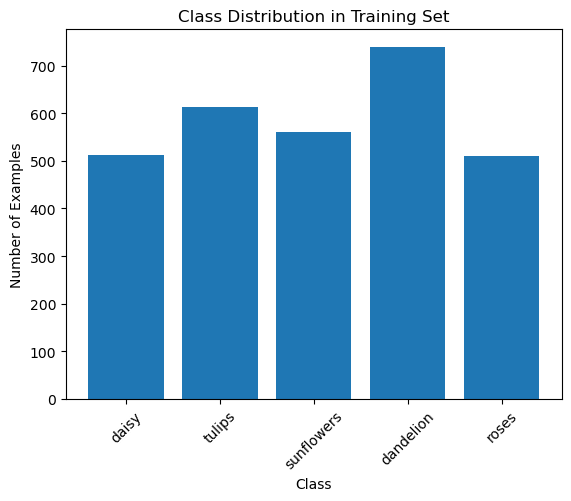

In [27]:
#FOR CHECKING PURPOSE

# Visualize class distribution in training set
plt.bar(class_counts_train.keys(), class_counts_train.values())
plt.xlabel('Class')
plt.ylabel('Number of Examples')
plt.title('Class Distribution in Training Set')
plt.xticks(rotation=45)
plt.show()

# Ensure balanced classes or check if dataset balancing function is effective


In [28]:
# Step 3: Augmenting images
print("Step 3: Augmenting images...")
augmented_ds_train = [(augment_image(image), label) for image, label in balanced_ds_train]


Step 3: Augmenting images...


In [29]:
# Step 4: Preprocessing images
print("Step 4: Preprocessing images...")
preprocessed_ds_train = [(preprocess_image(image), label) for image, label in augmented_ds_train]

Step 4: Preprocessing images...


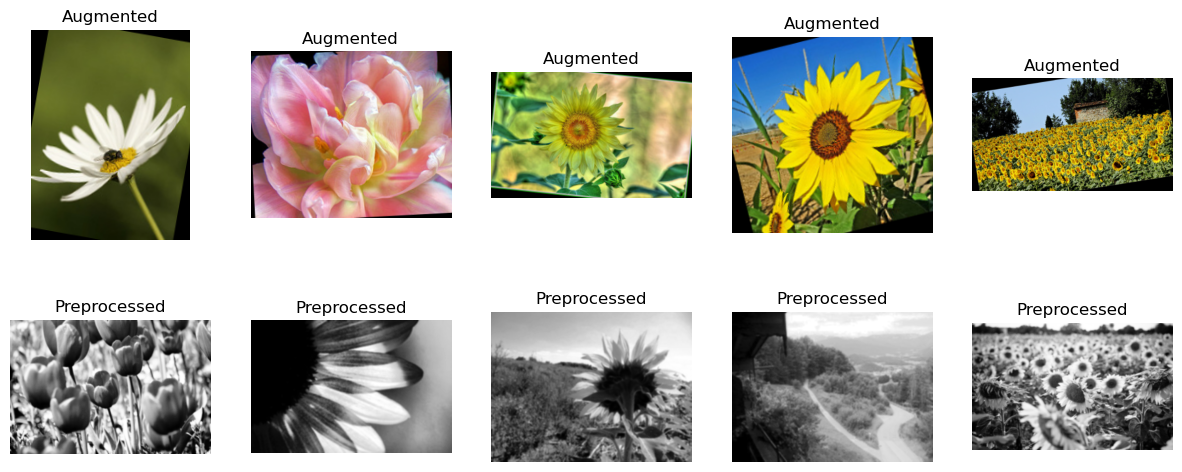

In [30]:
# Visualize some augmented and preprocessed images
num_samples = 5
augmented_samples = [augment_image(image) for image, _ in ds_train.take(num_samples)]
preprocessed_samples = [preprocess_image(image) for image, _ in ds_train.take(num_samples)]

plt.figure(figsize=(15, 6))
for i in range(num_samples):
    plt.subplot(2, num_samples, i + 1)
    plt.imshow(augmented_samples[i])
    plt.title('Augmented')
    plt.axis('off')

    plt.subplot(2, num_samples, num_samples + i + 1)
    plt.imshow(preprocessed_samples[i], cmap='gray')
    plt.title('Preprocessed')
    plt.axis('off')

plt.show()


Step 5: Displaying images from each class in the training set...


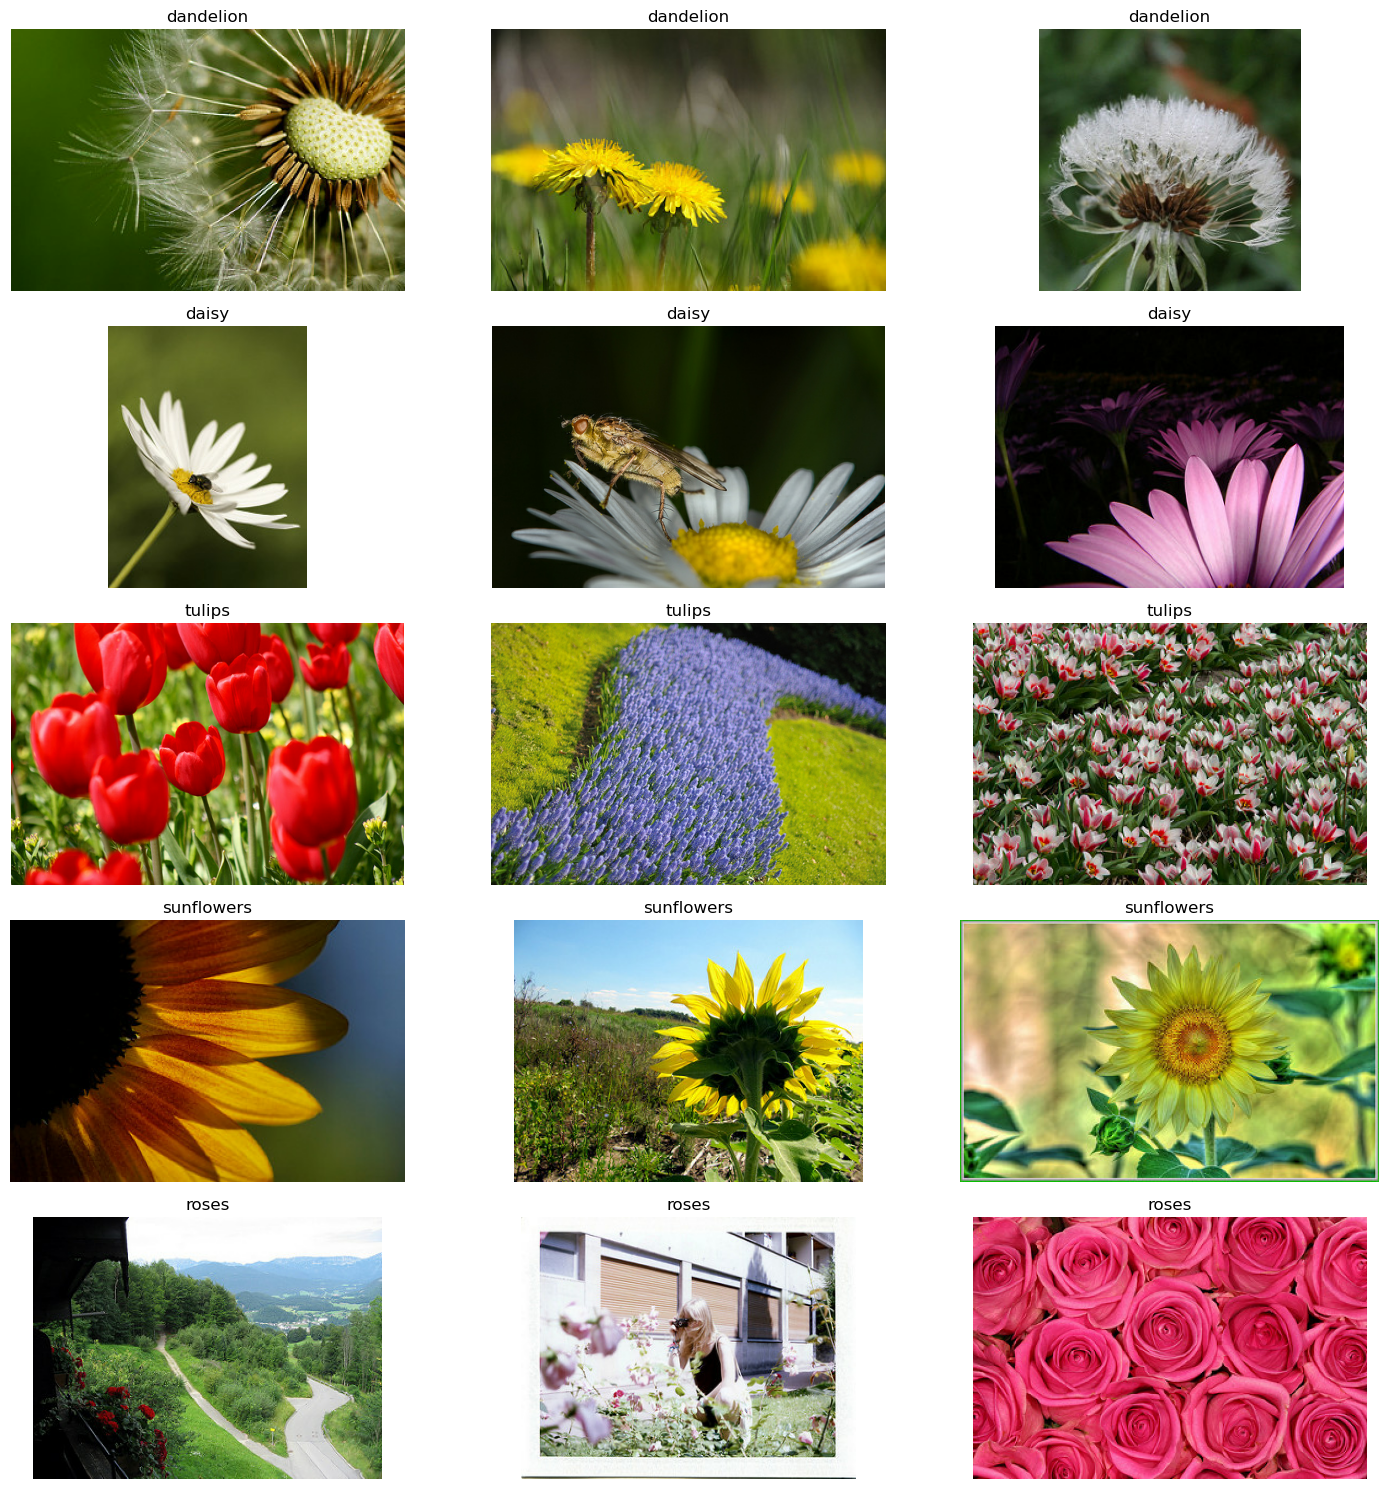

In [31]:
# Step 5: Displaying images from each class
print("Step 5: Displaying images from each class in the training set...")
display_images_from_each_class(ds_train, ds_info.features["label"].num_classes)

In [32]:
# Step 2: Feature Extraction Functions
def compute_hog_features(image):
    gray = image if len(image.shape) == 2 else cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    features = hog(gray, orientations=9, pixels_per_cell=(8, 8),
                   cells_per_block=(2, 2), block_norm='L2-Hys',
                   transform_sqrt=True)
    return features

In [33]:
def compute_lbp_features(image):
    gray = image if len(image.shape) == 2 else cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    lbp_radius = 1
    lbp_n_points = 8 * lbp_radius
    lbp = local_binary_pattern(gray, lbp_n_points, lbp_radius, method='uniform')
    hist, _ = np.histogram(lbp.ravel(), bins=np.arange(0, lbp_n_points + 3), range=(0, lbp_n_points + 2))
    hist = hist.astype("float")
    hist /= (hist.sum() + 1e-7)  # Normalize histogram
    return hist


In [34]:
base_model = tf.keras.applications.VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

def preprocess_input_image(image):
    img = cv2.resize(image, (224, 224))
    img = tf.keras.applications.vgg16.preprocess_input(img)
    return img

def extract_cnn_features(image, model):
    img = preprocess_input_image(image)
    img = np.expand_dims(img, axis=0)
    features = model.predict(img)
    return features.flatten()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 264ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

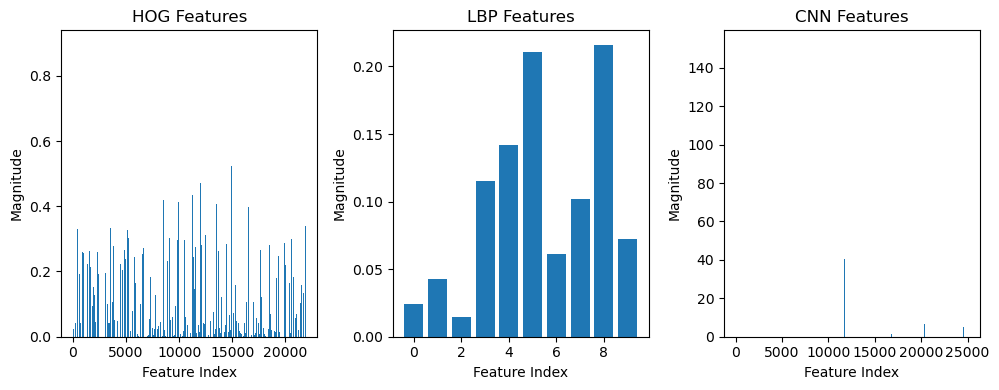

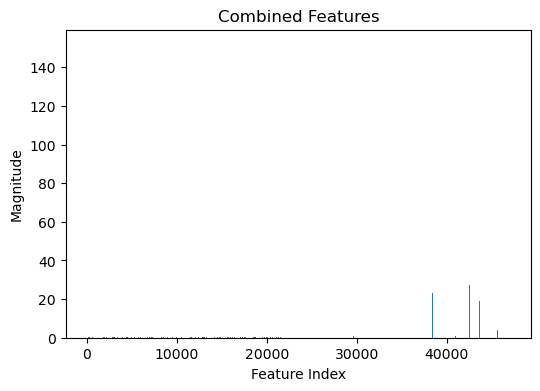

In [37]:
def extract_features(image, label, model):
    image = np.array(image)
    hog_features = compute_hog_features(image)
    lbp_features = compute_lbp_features(image)
    cnn_features = extract_cnn_features(image, model)
    combined_features = np.hstack([hog_features, lbp_features, cnn_features])
    return hog_features, lbp_features, cnn_features, combined_features, label.numpy()

# Assuming ds_train is your dataset
features_list = []
labels_list = []
hog_feature_list = []
lbp_feature_list = []
cnn_feature_list = []
combined_feature_list = []

for image, label in ds_train:
    hog_features, lbp_features, cnn_features, combined_features, label = extract_features(image.numpy(), label, base_model)
    hog_feature_list.append(hog_features)
    lbp_feature_list.append(lbp_features)
    cnn_feature_list.append(cnn_features)
    combined_feature_list.append(combined_features)
    labels_list.append(label)

# Find the maximum feature length
max_feature_length = max(len(f) for f in combined_feature_list)

# Pad features to ensure consistent length
features_list = [np.pad(f, (0, max_feature_length - len(f)), 'constant') for f in combined_feature_list]

# Convert lists to NumPy arrays
X = np.array(features_list, dtype=np.float32)
y = np.array(labels_list, dtype=np.int32)

print("Feature array shape after extraction and flattening:", X.shape)
print("Feature extraction completed.")

# Plotting
import matplotlib.pyplot as plt

# Display HOG features
plt.figure(figsize=(10, 4))
plt.subplot(1, 3, 1)
plt.bar(range(len(hog_feature_list[0])), hog_feature_list[0])
plt.title('HOG Features')
plt.xlabel('Feature Index')
plt.ylabel('Magnitude')

# Display LBP features
plt.subplot(1, 3, 2)
plt.bar(range(len(lbp_feature_list[0])), lbp_feature_list[0])
plt.title('LBP Features')
plt.xlabel('Feature Index')
plt.ylabel('Magnitude')

# Display CNN features
plt.subplot(1, 3, 3)
plt.bar(range(len(cnn_feature_list[0])), cnn_feature_list[0])
plt.title('CNN Features')
plt.xlabel('Feature Index')
plt.ylabel('Magnitude')

plt.tight_layout()
plt.show()

# Display Combined features
plt.figure(figsize=(6, 4))
plt.bar(range(len(combined_feature_list[0])), combined_feature_list[0])
plt.title('Combined Features')
plt.xlabel('Feature Index')
plt.ylabel('Magnitude')
plt.show()

In [38]:
# Import PCA module
from sklearn.decomposition import PCA

# Apply PCA with 100 components
pca = PCA(n_components=100)
X_pca = pca.fit_transform(X)

print("Feature array shape after PCA:", X_pca.shape)
print(f"Explained variance ratio of each component: {pca.explained_variance_ratio_}")
print(f"Total explained variance by selected components: {np.sum(pca.explained_variance_ratio_):.2f}")
print("PCA completed.")


Feature array shape after PCA: (2936, 100)
Explained variance ratio of each component: [0.03872851 0.02452585 0.01336769 0.00975145 0.00939761 0.00735776
 0.00716413 0.0065315  0.00623148 0.00538135 0.00475403 0.00422374
 0.00398412 0.00391024 0.00382167 0.00367648 0.00360887 0.00345622
 0.00336509 0.00324933 0.00311091 0.0029915  0.00296084 0.00293501
 0.0028259  0.00272931 0.00268523 0.00263627 0.00253278 0.00249794
 0.00240804 0.00232129 0.00227673 0.00226529 0.0021809  0.00207677
 0.00204003 0.00201928 0.00198997 0.00195835 0.0019319  0.00189758
 0.00186201 0.00183158 0.00177695 0.00176914 0.00172532 0.00171073
 0.00167745 0.00164224 0.00163923 0.00159639 0.00159255 0.00157926
 0.00156608 0.00156351 0.00155941 0.00150135 0.00149392 0.0014873
 0.00146193 0.0014429  0.00143896 0.00143281 0.00141125 0.00139781
 0.00138228 0.00137492 0.00137251 0.00135847 0.00133088 0.00131222
 0.0013076  0.00129643 0.0012895  0.00128235 0.00127173 0.00125771
 0.00124459 0.00123797 0.00123519 0.0012305

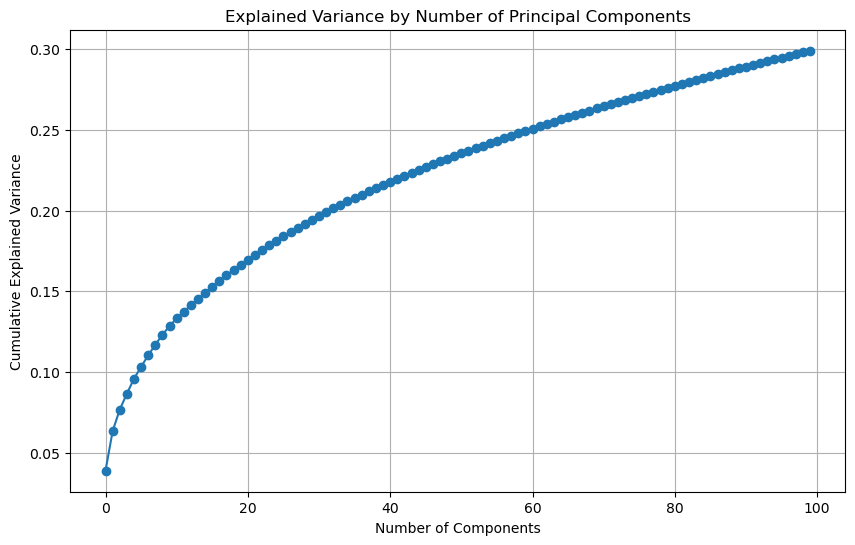

In [39]:
import matplotlib.pyplot as plt

# Plot the explained variance ratio
plt.figure(figsize=(10, 6))
plt.plot(np.cumsum(pca.explained_variance_ratio_), marker='o')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Explained Variance by Number of Principal Components')
plt.grid(True)
plt.show()


In [40]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

# Implement LDA
lda = LDA(n_components=4)  # The number of classes minus one
X_lda = lda.fit_transform(X, y)

print("LDA completed. Shape of X_lda:", X_lda.shape)


LDA completed. Shape of X_lda: (2936, 4)


In [41]:
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis as QDA

# Implement QDA (feature space remains the same)
qda = QDA()
qda.fit(X, y)
X_qda = qda.predict(X)  # This will be the predictions, not the reduced features


c:\Users\Hamza\anaconda3\Lib\site-packages\sklearn\discriminant_analysis.py:926: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


In [42]:
from sklearn.decomposition import FastICA

# Implement ICA
ica = FastICA(n_components=150, random_state=42)  # Adjust n_components as needed
X_ica = ica.fit_transform(X)

print("ICA completed. Shape of X_ica:", X_ica.shape)


c:\Users\Hamza\anaconda3\Lib\site-packages\sklearn\decomposition\_fastica.py:542: FutureWarning: Starting in v1.3, whiten='unit-variance' will be used by default.
  warnings.warn(


ICA completed. Shape of X_ica: (2936, 150)


In [43]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Split the dataset into training and testing sets
X_train_pca, X_test_pca, y_train, y_test = train_test_split(X_pca, y, test_size=0.2, random_state=42)
X_train_lda, X_test_lda, _, _ = train_test_split(X_lda, y, test_size=0.2, random_state=42)
X_train_ica, X_test_ica, _, _ = train_test_split(X_ica, y, test_size=0.2, random_state=42)

# Function to train and evaluate RandomForestClassifier
def evaluate_model(X_train, X_test, y_train, y_test):
    clf = RandomForestClassifier(n_estimators=100, random_state=42)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    return accuracy

# Evaluate each reduced feature set
accuracy_pca = evaluate_model(X_train_pca, X_test_pca, y_train, y_test)
accuracy_lda = evaluate_model(X_train_lda, X_test_lda, y_train, y_test)
accuracy_ica = evaluate_model(X_train_ica, X_test_ica, y_train, y_test)

print(f"Accuracy with PCA: {accuracy_pca:.4f}")
print(f"Accuracy with LDA: {accuracy_lda:.4f}")
print(f"Accuracy with ICA: {accuracy_ica:.4f}")


Accuracy with PCA: 0.7058
Accuracy with LDA: 0.9983
Accuracy with ICA: 0.5833


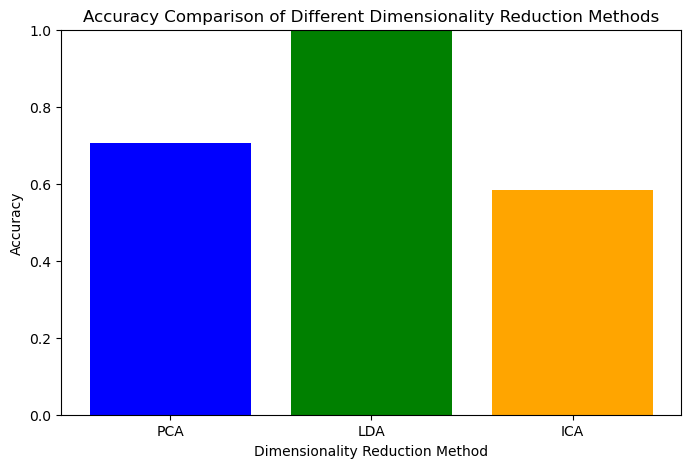

In [44]:
# Function to visualize the results
def visualize_results(acc_pca, acc_lda, acc_ica):
    methods = ['PCA', 'LDA', 'ICA']
    accuracies = [acc_pca, acc_lda, acc_ica]

    plt.figure(figsize=(8, 5))
    plt.bar(methods, accuracies, color=['blue', 'green', 'orange'])
    plt.title('Accuracy Comparison of Different Dimensionality Reduction Methods')
    plt.xlabel('Dimensionality Reduction Method')
    plt.ylabel('Accuracy')
    plt.ylim(0, 1)  # Setting y-axis limit from 0 to 1
    plt.show()

# Call the function to visualize results
visualize_results(accuracy_pca, accuracy_lda, accuracy_ica)

In [45]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
# Step 5: Classification using SVM
# Train SVM classifiers with different kernels
svm_linear = SVC(kernel='linear')
svm_poly = SVC(kernel='poly')
svm_rbf = SVC(kernel='rbf')

svm_linear.fit(X_train_pca, y_train)
svm_poly.fit(X_train_lda, y_train)
svm_rbf.fit(X_train_ica, y_train)

# Predictions
y_pred_linear = svm_linear.predict(X_test_pca)
y_pred_poly = svm_poly.predict(X_test_lda)
y_pred_rbf = svm_rbf.predict(X_test_ica)

# Evaluation
accuracy_linear = accuracy_score(y_test, y_pred_linear)
accuracy_poly = accuracy_score(y_test, y_pred_poly)
accuracy_rbf = accuracy_score(y_test, y_pred_rbf)

precision_linear = precision_score(y_test, y_pred_linear, average='weighted')
precision_poly = precision_score(y_test, y_pred_poly, average='weighted')
precision_rbf = precision_score(y_test, y_pred_rbf, average='weighted')

recall_linear = recall_score(y_test, y_pred_linear, average='weighted')
recall_poly = recall_score(y_test, y_pred_poly, average='weighted')
recall_rbf = recall_score(y_test, y_pred_rbf, average='weighted')

f1_linear = f1_score(y_test, y_pred_linear, average='weighted')
f1_poly = f1_score(y_test, y_pred_poly, average='weighted')
f1_rbf = f1_score(y_test, y_pred_rbf, average='weighted')

# Print evaluation metrics
print("SVM with linear kernel:")
print("Accuracy:", accuracy_linear)
print("Precision:", precision_linear)
print("Recall:", recall_linear)
print("F1-score:", f1_linear)

print("SVM with polynomial kernel:")
print("Accuracy:", accuracy_poly)
print("Precision:", precision_poly)
print("Recall:", recall_poly)
print("F1-score:", f1_poly)

print("SVM with RBF kernel:")
print("Accuracy:", accuracy_rbf)
print("Precision:", precision_rbf)
print("Recall:", recall_rbf)
print("F1-score:", f1_rbf)

SVM with linear kernel:
Accuracy: 0.641156462585034
Precision: 0.6441223409248111
Recall: 0.641156462585034
F1-score: 0.6373650735495681
SVM with polynomial kernel:
Accuracy: 0.6445578231292517
Precision: 0.4965986394557823
Recall: 0.6445578231292517
F1-score: 0.5400876019923638
SVM with RBF kernel:
Accuracy: 0.6649659863945578
Precision: 0.675779677310928
Recall: 0.6649659863945578
F1-score: 0.6619101744276328


c:\Users\Hamza\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


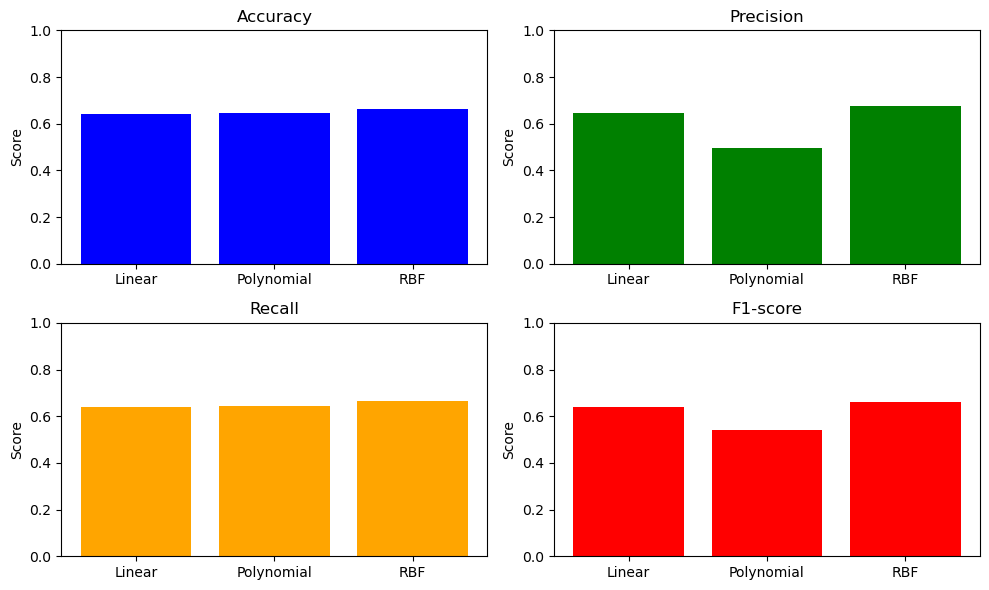

In [46]:
# Function to visualize the results
def visualize_svm_results(metrics, kernel_names):
    evaluation_metrics = ['Accuracy', 'Precision', 'Recall', 'F1-score']
    colors = ['blue', 'green', 'orange', 'red']
    
    plt.figure(figsize=(10, 6))
    for i, metric in enumerate(evaluation_metrics):
        plt.subplot(2, 2, i+1)
        plt.bar(kernel_names, metrics[i], color=colors[i])
        plt.title(metric)
        plt.ylim(0, 1)  # Setting y-axis limit from 0 to 1
        plt.ylabel('Score')

    plt.tight_layout()
    plt.show()

# Compile the metrics into lists
accuracies = [accuracy_linear, accuracy_poly, accuracy_rbf]
precisions = [precision_linear, precision_poly, precision_rbf]
recalls = [recall_linear, recall_poly, recall_rbf]
f1_scores = [f1_linear, f1_poly, f1_rbf]

# Call the function to visualize results
visualize_svm_results([accuracies, precisions, recalls, f1_scores], ['Linear', 'Polynomial', 'RBF'])